# Proyecto


In [ ]:
%load_ext autoreload
%autoreload 3

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

## 1: Importando bibliotecas


In [26]:
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

## 2: Creando nuestros ImageDataGenerators

Para este punto de la clase NO hemos hablado de `Data Augmentation` cosa que si has tomado este repositorio completo entonces ya debes conocer y entender. Ahora lo único que vamos a hacer es utilizar el `ImageDataGenerator` para normalizar las imágenes y esta clase nos permita generar un objeto con el método `frow_from_directory`

Nota: Algo interesante es que del test_dataget también vamos a construir el validation test, por haber definido el parámetro validation_split


In [3]:
train_dir = "../data/rice_dataset/Train"
test_dir = "../data/rice_dataset/Test"
val_dir = "../data/rice_dataset/Validation"

In [4]:
train_datagen = ImageDataGenerator(rescale=1 / 255)
test_datagen = ImageDataGenerator(rescale=1 / 255)
val_datagen = ImageDataGenerator(rescale=1 / 255, validation_split=0.3)

## 3: Creamos nuestros generadores de imágenes, para los conjuntos de train, validation y test


In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=64,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training",
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(28, 28),
    batch_size=64,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation",
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=64,
    class_mode="categorical",
    color_mode="grayscale",
)

Found 50000 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.
Found 12500 images belonging to 5 classes.


## 4: Generando el nombre de las clases

Sabemos que las clases están en label_encoding entonces hace falta definir el nombre de las labels de la siguiente manera


In [6]:
classes = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

print("Classes: ", classes)

Classes:  ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


## 5: Muestra de entrenamiento


Definimos una función auxiliar para mostrar imágenes:


In [7]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()

    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:, :, 0], cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

Generamos una muestra de 5 imágenes de nuestro `train_generator`


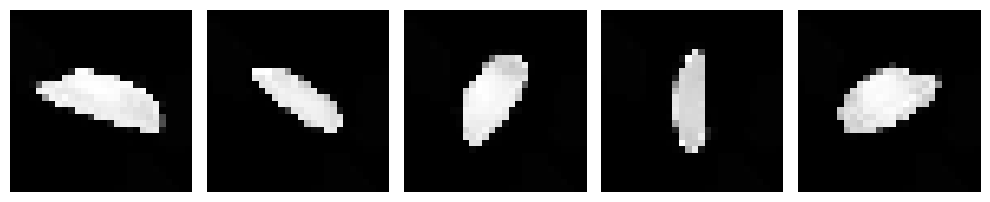

In [8]:
sample_trainnig_images, _ = next(train_generator)
plot_images(sample_trainnig_images[:5])

# Crear la red neuronal, definir capas, compilar, entrenar, evaluar y predicciones

Este será nuestra primera aproximación a resolver el problema de clasificación de aroz


In [9]:
def plot_results(history_, metric):
    history_dict = history_.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    metric_values = history_dict[metric]
    val_metric_values = history_dict[f"val_{metric}"]

    epoch = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    fig.suptitle("Neural Network's Result")
    ax[0].set_title("Loss function over epoch")
    ax[0].set(ylabel="loss", xlabel="epoch")
    ax[0].plot(epoch, loss_values, "go-", label="training")
    ax[0].plot(epoch, val_loss_values, "ro-", label="validation")
    ax[0].legend()

    ax[1].set_title(f"{metric} over epoch")
    ax[1].set(ylabel=metric, xlabel="epochs")
    ax[1].plot(epoch, metric_values, "go-", label="training")
    ax[1].plot(epoch, val_metric_values, "ro-", label="validation")
    ax[1].legend()
    plt.show()

## 6: Crear la arquitectura base del modelo


In [ ]:
def base_architecture(input_shape: tuple, n_clases: int):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(n_clases, activation="softmax"))
    print(model.summary())
    return model

Llamamos a nuestra función auxiliar en nuestro ciclo principal.


In [ ]:
base_model = base_architecture(input_shape=(28, 28, 1), n_clases=len(classes))

## 7: Compilamos el modelo


In [ ]:
base_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
)

Recordemos que como es un problema de clasificación multiple nuestra perdida debe ser: `categorical_crossentropy` y la última capa de clasificación del modelo tendrá 24 neuronas una por cada clase disponible y a su vez esto nos hace necesitar usar `softmax` como función de activación.


## 8: Entrenamos el modelo


In [ ]:
history = base_model.fit(
    train_generator, epochs=10, validation_data=validation_generator, batch_size=64
)

## 9: Análisis de resultados


In [ ]:
plot_results(history, "accuracy")

results = base_model.evaluate(test_generator)

Para resumir, la estructura en código de este ejercicio fue:


Para este momento hemos conseguido un `accuracy` del **97.577%** del modelo


La estructura de código de esta clase se mantiene igual a la de la clase anterior, el único cambio relevante es el cambio de la arquitectura base del modelo por una regularizada:


In [ ]:
def base_architecture_w_regularizes(input_shape, n_clases):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(n_clases, activation="softmax"))
    print(model.summary())
    return model

In [ ]:
regularized_model = base_architecture_w_regularizes(
    input_shape=(28, 28, 1), n_clases=len(classes)
)

In [ ]:
regularized_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
)

In [ ]:
history_regularized = regularized_model.fit(
    train_generator, epochs=10, validation_data=validation_generator, batch_size=64
)

In [ ]:
plot_results(history_regularized, "accuracy")

results_regularized = regularized_model.evaluate(test_generator)

In [10]:
def conv_architecture(input_shape, n_clases):
    model = Sequential()
    model.add(
        Conv2D(
            filters=128, kernel_size=(3, 3), activation="relu", input_shape=input_shape
        )
    )
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(n_clases, activation="softmax"))
    print(model.summary())
    return model

In [14]:
conv_model = conv_architecture(input_shape=(28, 28, 1), n_clases=len(classes))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 128)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 256)               5538048   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                      

In [15]:
conv_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
)

In [ ]:
history_conv = conv_model.fit(
    train_generator, epochs=10, validation_data=validation_generator, batch_size=64
)

In [ ]:
plot_results(history_conv, "accuracy")

results_conv = conv_model.evaluate(test_generator)

## Métricas para medir la eficiencia de un modelo: Callback


En este ejemplo vamos a definir un pequeño `Custom Callback`

Supongamos que queremos detener el proceso de entrenamiento del modelo cuando el mismo haya logrado alcanzar al menos 80% de accuracy en el set de validación.

Lo único que necesitamos hacer es crear una clase que contenga nuestra `CustoCallback`:


In [11]:
class TrainingCallback(Callback):

    def __init__(self, acc_stop):
        super().__init__()
        self.acc_stop = acc_stop

    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy") > self.acc_stop:
            print(f"Lo hemos logrado! El modelo ha llegado a un {self.acc_stop * 100}%")
            self.model.stop_training = True

Existen varios overrides que podemos hacer para crear nuestras Callbacks propias, entre ellas podemos encontrar las siguientes:


In [ ]:
from keras.callbacks import Callback


class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training....")

    def on_epoch_begin(self, epoch, logs=None):
        print("Starting epoch {}".format(epoch))

    def on_train_batch_begin(self, batch, logs=None):
        print("Training: Starting batch {}".format(batch))

    def on_train_batch_end(self, batch, logs=None):
        print("Training: Finished batch {}".format(batch))

    def on_epoch_end(self, epoch, logs=None):
        print("Finished epoch {}".format(epoch))

    def on_train_end(self, logs=None):
        print("Finished training!")


class TestingCallback(Callback):
    def on_test_begin(self, logs=None):
        print("Starting testing....")

    def on_test_batch_begin(self, batch, logs=None):
        print("Testing: Starting batch {}".format(batch))

    def on_test_batch_end(self, batch, logs=None):
        print("Testing: Finished batch {}".format(batch))

    def on_test_end(self, logs=None):
        print("Finished testing!")


class PredictionCallback(Callback):
    def on_predict_begin(self, logs=None):
        print("Prediction testing....")

    def on_predict_batch_begin(self, batch, logs=None):
        print("Prediction: Starting batch {}".format(batch))

    def on_predict_batch_end(self, batch, logs=None):
        print("Prediction: Finished batch {}".format(batch))

    def on_predict_end(self, logs=None):
        print("Finished prediction!")

In [20]:
callback_my = TrainingCallback(acc_stop=0.95)

In [21]:
history_conv = conv_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    batch_size=64,
    callbacks=[callback_my],
)

Epoch 1/20
782/782 [==============================] - 45s 58ms/step - loss: 0.1178 - accuracy: 0.9642 - val_loss: 0.1056 - val_accuracy: 0.9693


Aquí el proceso se ha detenido a pesar de que le hemos pedido que hiciera 10 epochs esto muestra como hemos hecho funcionar correctamente nuestra propuesta de EarlyStop basada en el val_accuracy.


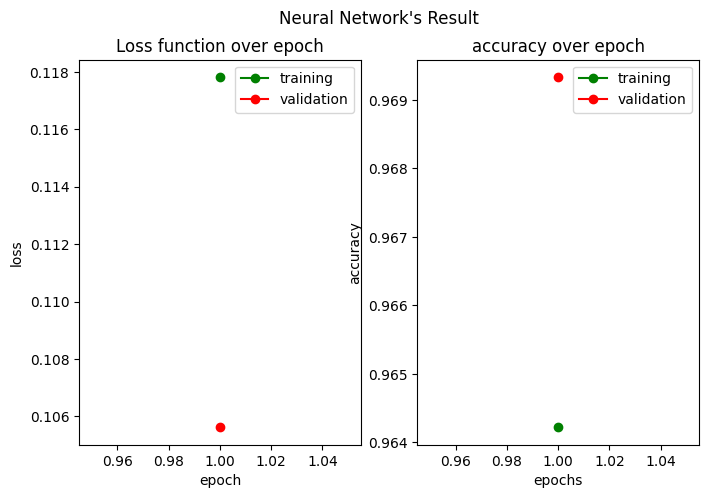

196/196 [==============================] - 4s 22ms/step - loss: 0.0952 - accuracy: 0.9733


In [22]:
plot_results(history_conv, "accuracy")

results_conv = conv_model.evaluate(test_generator)

## Monitoreo del entrenamiento en tiempo real: early stopping y patience


In [24]:
callback_early = EarlyStopping(monitor="val_accuracy", patience=3, mode="auto")

history_conv = conv_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    batch_size=64,
    callbacks=[callback_early],
)

Epoch 1/20
782/782 [==============================] - 45s 58ms/step - loss: 0.1119 - accuracy: 0.9673 - val_loss: 0.1048 - val_accuracy: 0.9707
Epoch 2/20
782/782 [==============================] - 44s 56ms/step - loss: 0.1049 - accuracy: 0.9700 - val_loss: 0.1071 - val_accuracy: 0.9717
Epoch 3/20
782/782 [==============================] - 46s 58ms/step - loss: 0.1009 - accuracy: 0.9723 - val_loss: 0.1156 - val_accuracy: 0.9656
Epoch 4/20
782/782 [==============================] - 45s 57ms/step - loss: 0.0972 - accuracy: 0.9728 - val_loss: 0.1063 - val_accuracy: 0.9709
Epoch 5/20
782/782 [==============================] - 44s 56ms/step - loss: 0.0943 - accuracy: 0.9743 - val_loss: 0.1086 - val_accuracy: 0.9723
Epoch 6/20
782/782 [==============================] - 43s 55ms/step - loss: 0.0894 - accuracy: 0.9766 - val_loss: 0.1023 - val_accuracy: 0.9723
Epoch 7/20
782/782 [==============================] - 43s 55ms/step - loss: 0.0852 - accuracy: 0.9771 - val_loss: 0.1324 - val_accuracy:

El mejor histórico lo alcanzo en la época 3 con un val_accuracy de 0.8568 y como durante 3 épocas NO mejoro este resultado, entonces automáticamente detuvo el proceso de entrenamiento.


### PLUS: guardando el modelo con checkpoints

Crearemos otro callback para guardar el modelo cada que encuentre una época que optimice el parámetro de accuracy. Lo guardaremos en la carpeta models con el nombre de: best_model.keras


In [27]:
checkpoint = ModelCheckpoint(
    filepath="../model/best_model.keras",
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    verbose=1,
    monitor="val_accuracy",
)

In [28]:
history_conv = conv_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    batch_size=64,
    callbacks=[callback_early, checkpoint],
)

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9793
Epoch 1: val_accuracy improved from -inf to 0.97067, saving model to ../model\best_model.keras
782/782 [==============================] - 44s 57ms/step - loss: 0.0788 - accuracy: 0.9793 - val_loss: 0.1087 - val_accuracy: 0.9707
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9806
Epoch 2: val_accuracy improved from 0.97067 to 0.97573, saving model to ../model\best_model.keras
782/782 [==============================] - 43s 55ms/step - loss: 0.0740 - accuracy: 0.9806 - val_loss: 0.0930 - val_accuracy: 0.9757
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9803
Epoch 3: val_accuracy improved from 0.97573 to 0.97600, saving model to ../model\best_model.keras
782/782 [==============================] - 44s 57ms/step - loss: 0.0747 - accuracy: 0.9802 - val_loss: 0.0978 - val_accuracy: 0.9760
Epoch 4/20
781/782 [==

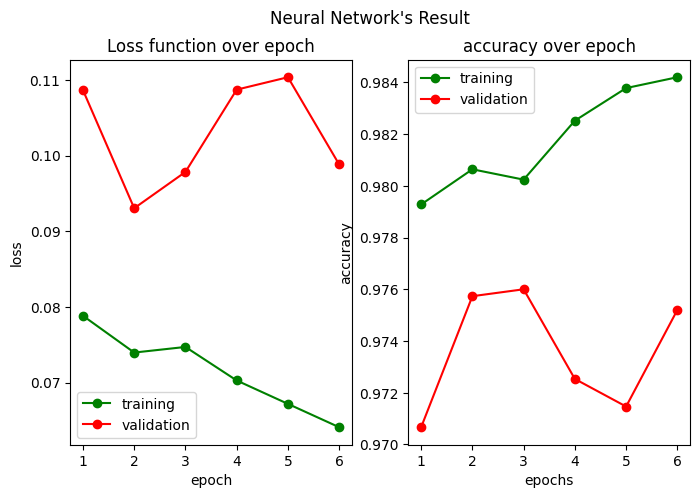

196/196 [==============================] - 4s 20ms/step - loss: 0.0848 - accuracy: 0.9780


In [30]:
plot_results(history_conv, "accuracy")

results_conv = conv_model.evaluate(test_generator)